<a href="https://colab.research.google.com/github/dtoralg/INESDI_Data-Science_ML_IA/blob/main/%5B06%5D%20-%20Deep%20Learning/De_MLP_a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CNN basico — Fashion-MNIST (end‑to‑end)

Este notebook entrena un **CNN** sobre **Fashion‑MNIST** usando TensorFlow/Keras.
- Dataset **online y fijo** (se descarga automáticamente la primera vez).
- Código **paso a paso**, sencillo y con buenas prácticas mínimas.
- Incluye **EarlyStopping**, **conjunto de validación estratificado**, **curvas de entrenamiento** y **predicciones de ejemplo**.



In [3]:
# =============================
# 1) Imports
# =============================
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

print(tf.__version__)

2.19.0


In [ ]:
# =============================
# 2) Carga de datos
# =============================
# Fashion-MNIST: (60k train, 10k test), imágenes 28x28 en escala de grises (uint8 0..255)
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
# =============================
# 3) Preprocesado
# =============================

# Importante: para CNN NO aplanamos.
# a) Normalizamos a [0,1]
X_train_full = X_train_full.astype("float32") / 255.0
X_test       = X_test.astype("float32") / 255.0

# b) Añadimos el canal (Escala de grises) -> (N, 28, 28, 1), si es RGB Color -> (N, 28, 28, 3)
#   Muchas APIs de Keras esperan el canal explícito para Conv2D.
X_train_full = X_train_full[..., None]  # (60000, 28, 28, 1)
X_test       = X_test[..., None]        # (10000, 28, 28, 1)
#Añadimos esa dimensión porque una CNN necesita saber cuántos canales tiene la imagen. En gris es 1, en color son 3. Sin ese eje, Conv2D no puede crear sus filtros ni procesar el batch correctamente.
#las capas Conv2D esperan tensores 4D (batch, height, width, channels)  ==  (N, 28, 28, 1)

In [4]:
# =============================
# 4) Split estratificado: TRAIN -> TRAIN + VAL
# =============================
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,            # 20% a validación
    random_state=42,
    stratify=y_train_full  #Mantiene (lo mejor posible) la misma proporción de cada clase
)

print("Shapes:")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   " y_val:  ", y_val.shape)
print("  X_test: ", X_test.shape,  " y_test: ", y_test.shape)


Shapes:
  X_train: (48000, 28, 28, 1)  y_train: (48000,)
  X_val:   (12000, 28, 28, 1)  y_val:   (12000,)
  X_test:  (10000, 28, 28, 1)  y_test:  (10000,)


In [5]:
# =============================
# 5) Definición del MODELO CNN
# =============================
# Arquitectura sencilla:
# Conv(32, 3x3) + ReLU -> Conv(64, 3x3) + ReLU -> MaxPool -> Dropout
# Conv(128, 3x3) + ReLU -> MaxPool -> Dropout
# Flatten -> Dense(128) + ReLU -> Dropout -> Dense(10) + Softmax
def build_cnn(input_shape=(28, 28, 1), num_classes=10) -> keras.Model:
    inputs = layers.Input(shape=input_shape)

    # Bloque 1
    x = layers.Conv2D(32, kernel_size=3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)            # reduce a la mitad H y W
    x = layers.Dropout(0.25)(x)                        # regulariza

    # Bloque 2
    x = layers.Conv2D(128, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Dropout(0.25)(x)

    # Clasificador
    x = layers.Flatten()(x)                            # pasa a vector 1D
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cnn_fashion_mnist")
    return model

model = build_cnn(input_shape=(28,28,1), num_classes=10)
model.summary()


Model: "cnn_fashion_mnist"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,906 (3.42 MB)

 Trainable params: 896,906 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# =============================
# 6) Compilación
# =============================
# - Adam con LR por defecto (1e-3) funciona bien; puedes bajar a 3e-4 si ves oscilaciones.
# - Pérdida: SparseCategoricalCrossentropy (etiquetas enteras 0..9).
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["sparse_categorical_accuracy"] #"sparse_categorical_accuracy" es la versión explícita para clasificación multiclase con etiquetas enteras (0..9)
)

In [7]:
# =============================
# 7) Callbacks útiles
# =============================
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",        # métrica a vigilar (minimizar)
    patience=3,                # épocas de “margen” sin mejora
    restore_best_weights=True  # vuelve a los mejores pesos
)
#EarlyStopping te deja el estado en RAM de la mejor época.

checkpoint = keras.callbacks.ModelCheckpoint(
    "cnn_fashion_mnist.keras",    # ruta/plantilla de guardado
    monitor="val_loss",           # métrica a elegir “lo mejor”
    save_best_only=True           # guarda solo cuando mejora
)
#Checkpoint te deja un archivo para recargar luego (p. ej. tras cerrar notebook).

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",  # métrica a vigilar
    factor=0.5,          # multiplica lr por este factor (lr *= 0.5)
  patience=2,            # épocas sin mejora antes de bajar lr
    verbose=1            # Mensaje en consola 1 o 0
)
# Cuando monitor no mejora durante patience épocas, reduce la tasa de aprendizaje.

In [9]:
# =============================
# 8) Entrenamiento
# =============================
# Nota: batch_size 128/256 suele ir bien en CNN pequeñas.
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,  #es cuántas muestras le das de golpe al modelo antes de hacer una actualización de pesos. Es el tamaño del “mini-lote”
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=2
)

#Con Fashion-MNIST y test_size=0.2, el train tiene 48 000 muestras. Con batch_size=128 → steps_per_epoch = 48 000 / 128 = 375 pasos por época.
#Regla practica
#Empieza con 64–256. Si te da OOM (out of memory), baja el batch_size.
#Si aumentas el batch, considera subir el learning rate de forma aproximadamente lineal (p. ej., doblar batch → ~doblar LR) y revisa estabilidad.

Epoch 1/20
375/375 - 299s - 799ms/step - loss: 0.4283 - sparse_categorical_accuracy: 0.8476 - val_loss: 0.3090 - val_sparse_categorical_accuracy: 0.8842 - learning_rate: 1.0000e-03
Epoch 2/20
375/375 - 304s - 810ms/step - loss: 0.3361 - sparse_categorical_accuracy: 0.8803 - val_loss: 0.2441 - val_sparse_categorical_accuracy: 0.9104 - learning_rate: 1.0000e-03
Epoch 3/20
375/375 - 303s - 809ms/step - loss: 0.2894 - sparse_categorical_accuracy: 0.8961 - val_loss: 0.2258 - val_sparse_categorical_accuracy: 0.9174 - learning_rate: 1.0000e-03
Epoch 4/20
375/375 - 301s - 803ms/step - loss: 0.2646 - sparse_categorical_accuracy: 0.9034 - val_loss: 0.2146 - val_sparse_categorical_accuracy: 0.9224 - learning_rate: 1.0000e-03
Epoch 5/20
375/375 - 318s - 849ms/step - loss: 0.2486 - sparse_categorical_accuracy: 0.9100 - val_loss: 0.2060 - val_sparse_categorical_accuracy: 0.9236 - learning_rate: 1.0000e-03
Epoch 6/20
375/375 - 301s - 803ms/step - loss: 0.2287 - sparse_categorical_accuracy: 0.9163 - v

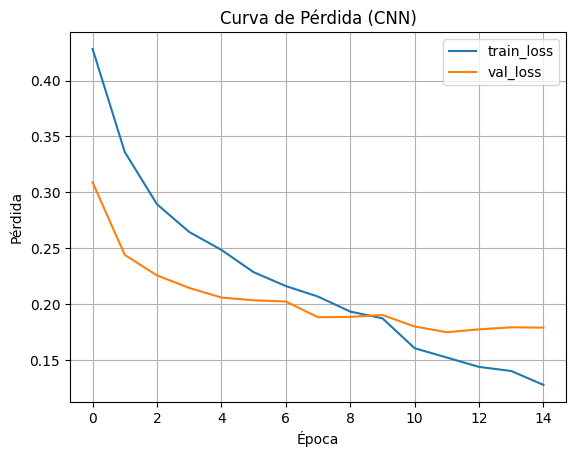

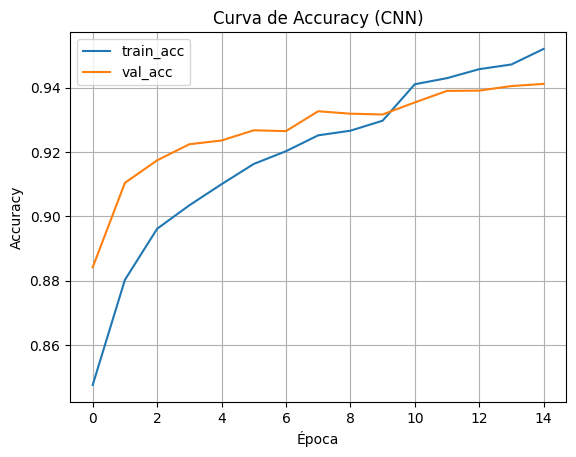

In [10]:
# =============================
# 9) Curvas de entrenamiento
# =============================
hist = history.history

plt.figure()
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title("Curva de Pérdida (CNN)")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(hist["sparse_categorical_accuracy"], label="train_acc")
plt.plot(hist["val_sparse_categorical_accuracy"], label="val_acc")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.title("Curva de Accuracy (CNN)")
plt.legend(); plt.grid(True); plt.show()


In [11]:
# =============================
# 10) Evaluación en TEST
# =============================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test — loss: {test_loss:.4f}  acc: {test_acc:.4f}")


Test — loss: 0.1973  acc: 0.9306


              precision    recall  f1-score   support

           0     0.8764    0.8860    0.8812      1000
           1     0.9950    0.9860    0.9905      1000
           2     0.8802    0.9180    0.8987      1000
           3     0.9276    0.9350    0.9313      1000
           4     0.8809    0.8950    0.8879      1000
           5     0.9900    0.9920    0.9910      1000
           6     0.8099    0.7540    0.7809      1000
           7     0.9685    0.9830    0.9757      1000
           8     0.9910    0.9890    0.9900      1000
           9     0.9827    0.9680    0.9753      1000

    accuracy                         0.9306     10000
   macro avg     0.9302    0.9306    0.9302     10000
weighted avg     0.9302    0.9306    0.9302     10000



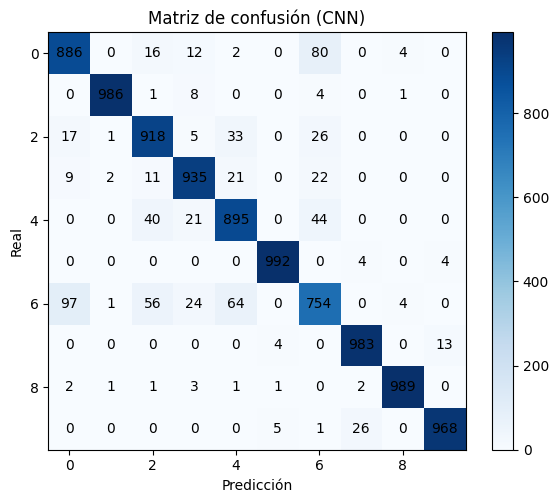

In [12]:
# =============================
# 11) Reporte por clase y matriz de confusión (opcional)
# =============================
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de confusión (CNN)")
plt.xlabel("Predicción"); plt.ylabel("Real")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.colorbar(); plt.tight_layout(); plt.show()
